# Prediction of houses sale price
## 1-Introduction
In this project we build a **linear regression model** to predict house sale price for the city of Ames, Iowa, United States. 
The data set has been used consists of data about housing in the city of Ame from 2006 to 2010.
First we clean the dataset and then select the efficient features to train the model. 
Afterwards we fit the model and evaluate it using **K fold cross validation** method. 


## 2-settig up the environment

In [1]:
#import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score


## 3-reading the data and initial inspection

In [2]:
#read the dataset and display basic info
housing=pd.read_csv('/Users/azid1/Desktop/data science in dataquest/housing_data.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   area             2930 non-null   int64  
 3   price            2930 non-null   int64  
 4   MS.SubClass      2930 non-null   int64  
 5   MS.Zoning        2930 non-null   object 
 6   Lot.Frontage     2440 non-null   float64
 7   Lot.Area         2930 non-null   int64  
 8   Street           2930 non-null   object 
 9   Alley            198 non-null    object 
 10  Lot.Shape        2930 non-null   object 
 11  Land.Contour     2930 non-null   object 
 12  Utilities        2930 non-null   object 
 13  Lot.Config       2930 non-null   object 
 14  Land.Slope       2930 non-null   object 
 15  Neighborhood     2930 non-null   object 
 16  Condition.1      2930 non-null   object 
 17  Condition.2   

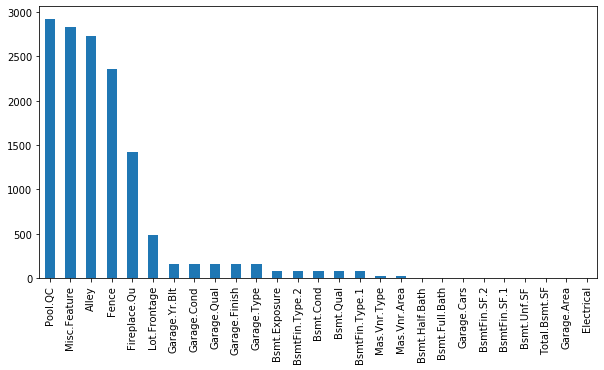

In [3]:
#display the number of null values in different columns
null_columns=housing.isnull().sum()
mask=null_columns!=0
null_columns=null_columns[mask].sort_values(ascending=False)
null_columns.plot.bar(figsize=(10,5))


## 4-feature engineering
- **null values** <br>
 we drop all features with more than 5% null values and text-features with less than 5% . the numeric-features with less than 5% null values will be replaced with their mean. 
- **domain-dependent feature transformation** <br>
in this part we transform features based on domain-dependent knowledge. in our case the age of houses could be more relevant than the year of selling or remodel.  
- **categorical features**<br>
we keep categorical features with less than 10 categories as dummy-coded data and drop the rest. 
- **text features**<br>
after previous steps all remained text-columns will be droped.
- **low-correlated features** <br>
among remained numeric features, those which have a high correlation with object column will be kept.


In [4]:
#drop columns with null values more than 5%
mask=housing.isnull().sum()<len(housing)/20
housing=housing.loc[:,mask]

#drop text-columns with null values less than 5%
obj_cols_null=(housing.select_dtypes(include=['object']).isnull().sum())>0
obj_cols_null=obj_cols_null[obj_cols_null==1].index
obj_cols_null
housing=housing.drop(columns=obj_cols_null)
#numeric-columns with null values less then 5% are replaced with mean of column.
housing=housing.fillna(housing.mean())

In [5]:
#making sure that all null values have been dealt with
housing.isnull().sum().value_counts()

0    64
dtype: int64

In [6]:
#transform featues based on domain-dependent info
housing['age']= housing['Yr.Sold'] - housing['Year.Built']
housing['years since remod'] = housing['Yr.Sold'] - housing['Year.Remod.Add']
housing=housing.drop(columns=['Yr.Sold', 'Year.Built', 'Year.Remod.Add'])

#drop categorical features with unique value more than 10
categorical_features=["PID", "MS.SubClass", "MS.Zoning", "Street", "Land.Contour", "Lot.Config", "Neighborhood", 
                    "Condition.1", "Condition.2", "Bldg.Type", "House.Style", "Roof.Style", "Roof.Matl", "Exterior.1st", 
                    "Exterior.2nd", "Foundation", "Heating", "Central.Air", 
                    "Sale.Condition"]
unique_k= [feature for feature in categorical_features if len(housing[feature].unique())>10 ]
housing= housing.drop(columns=unique_k)

#change the type of objects columns to category
text_features=housing.select_dtypes(include=['object']).columns
for feature in text_features:
    housing[feature]=housing[feature].astype('category')
    dummy=pd.get_dummies(housing[feature])
    housing= pd.concat([housing, dummy], axis=1)
    
#drop text-columns
housing= housing.drop(columns=text_features)

#drop columns with correlation less than 0.4
abs_corr=housing.corr()['price'].abs()
low_corr_cols=abs_corr[abs_corr<0.4].index
housing=housing.drop(columns=low_corr_cols)



## 5-train and test
in this part we create a linear regression model to predict new data. the efficiency of the model is tested by **K-fold cross validation** method. we analyze the change of **MSE** based on diffenet K folds. 

In [7]:
def train_and_test_k(df,k):
    """
    this function builds a linear redression model and returns rmses for different k folds.
    scoring="neg_mean_squared_error"
    
    parameters
    ----------
    df: class DataFrame
    k: int
    
    returns
    -------
    class list
    
    """
    #select features
    features = df.columns.drop("price")
    #make an instance of model
    lr=LinearRegression()
    #test the model
    kf=KFold(k,shuffle=True,random_state=1)
    mses=cross_val_score(lr,df[features],df["price"],scoring="neg_mean_squared_error",cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    return avg_rmse, mses

def train_and_test_k_r2(df,k):
    """
    this function builds a linear redression model and returns rmses for different k folds.
    scoring="r2"
    
    parameters
    ----------
    df: class DataFrame
    k: int
    
    returns
    -------
    class list
    
    """
    #select features
    features = df.columns.drop("price")
    #make an instance of model
    lr=LinearRegression()
    #test the model
    kf=KFold(k,shuffle=True,random_state=1)
    mses=cross_val_score(lr,df[features],df["price"],scoring="r2",cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    return avg_rmse, mses

[34567.367687765916, 34845.35582572719, 34312.0799084542, 34744.8245538295, 34725.133509760046, 34543.257415604436, 34356.868372004945, 34581.12142455496, 34224.00676920979]


Text(0, 0.5, 'avg-RMSE')

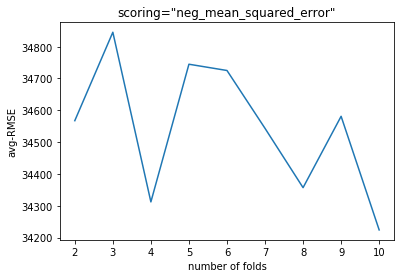

In [8]:
# k in range 2:5 and scoring="neg_mean_squared_error"
avg_rmse_list=[]
for k in range(2,11):
    avg_rmse_list.append(train_and_test_k(housing,k)[0])
print(avg_rmse_list)

fig , ax = plt.subplots()
ax.plot(range(2,11), avg_rmse_list)
plt.title('scoring="neg_mean_squared_error"')
plt.xlabel('number of folds')
plt.ylabel('avg-RMSE')

[0.9014594986348381, 0.8994839967377639, 0.902208722859857, 0.8988543605486881, 0.8972107188248025, 0.8983035347943306, 0.899321800664477, 0.896711175092856, 0.8997784865597458]


Text(0, 0.5, 'avg-RMSE')

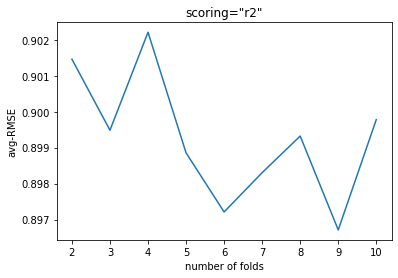

In [9]:
# k in range 2:5 and scoring="r2"
avg_rmse_list=[]
for k in range(2,11):
    avg_rmse_list.append(train_and_test_k_r2(housing,k)[0])
print(avg_rmse_list)

fig , ax = plt.subplots()
ax.plot(range(2,11), avg_rmse_list)
plt.title('scoring="r2"')
plt.xlabel('number of folds')
plt.ylabel('avg-RMSE')